# DNS Measurement Analysis
This notebook analyzes the DNS measurement results stored in the SQLite database `dns_measurements.sqlite`.

---

In [ ]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load data
conn = sqlite3.connect('dns_measurements.sqlite')
df = pd.read_sql_query('SELECT * FROM results', conn)
conn.close()

df.head()

,msm_id,domain,resolver,prb_id,rt,size,src_addr,dst_addr,timestamp,err,err_msg
0,107070584,google.com,local,6332,NaN,NaN,None,None,1.748826e+09,0,None
1,107070584,google.com,local,6332,NaN,NaN,None,None,1.748826e+09,0,None
2,107070584,google.com,local,6357,NaN,NaN,None,None,1.748826e+09,0,None
3,107070584,google.com,local,6357,NaN,NaN,None,None,1.748826e+09,0,None
4,107070584,google.com,local,6368,NaN,NaN,None,None,1.748826e+09,0,None


In [ ]:
# count the number of overall entries in the err column
err_count = df['err'].value_counts()
print(err_count)


err
1    150261
0     80191
Name: count, dtype: int64


## 1. Distribution of Successful vs Erroneous Measurements (Pie Chart)

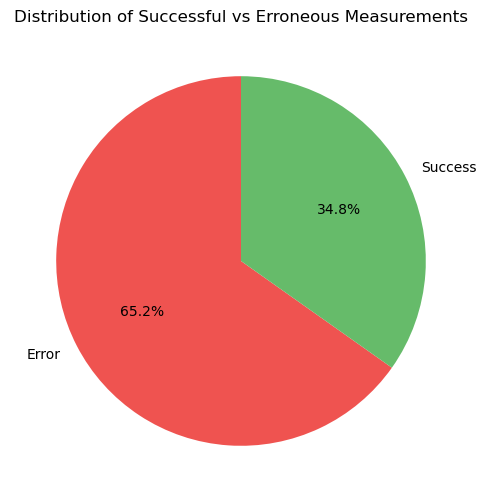

In [ ]:
success_counts = df['err'].value_counts()
labels = ['Error', 'Success']
plt.figure(figsize=(6, 6))
plt.pie(success_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ef5350', '#66bb6a'])
plt.title('Distribution of Successful vs Erroneous Measurements')
plt.show()

## 2. Distribution of Different Error Messages (Pie Chart)

/tmp/ipykernel_39871/2914311820.py:44: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


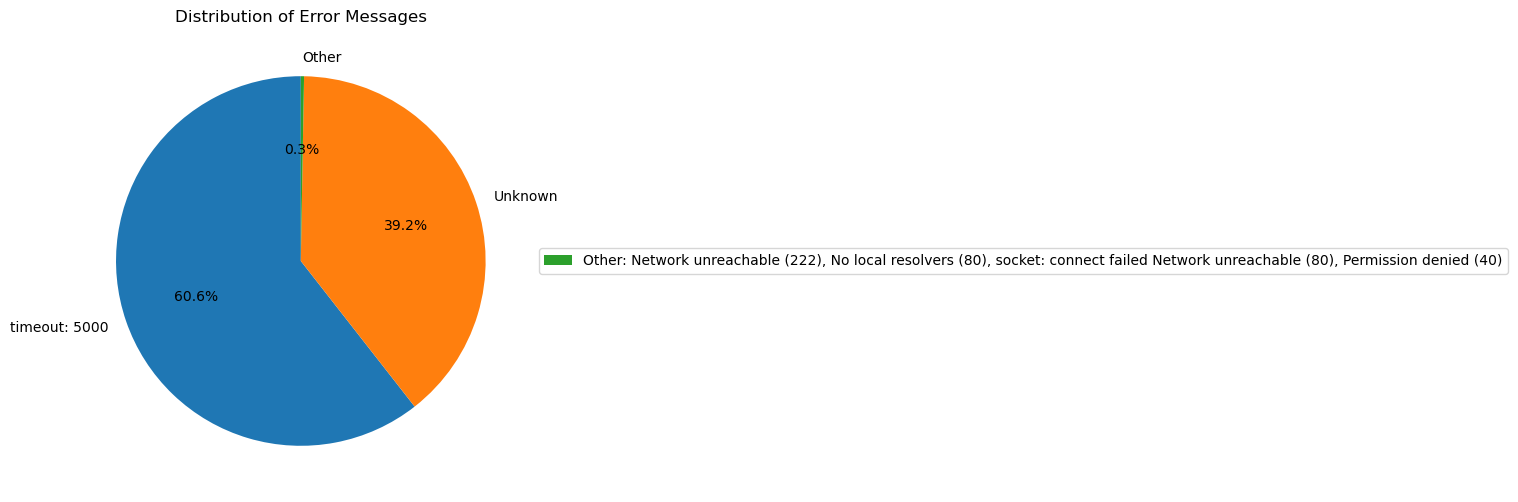

In [ ]:
def normalize_err_msg(msg):
    if not isinstance(msg, str):
        msg = str(msg)
    # Gruppiere alle Timeouts
    if "timeout" in msg or "5000" in msg:
        return "timeout: 5000"
    if "Network is unreachable" in msg:
        return "Network unreachable"
    if "Permission denied" in msg:
        return "Permission denied"
    if "no local resolvers found" in msg:
        return "No local resolvers"
    if msg.strip() in ("nan", "", "None", "unknown", "Unknown"):
        return "Unknown"
    return msg

err_msgs = df[df['err'] == 1]['err_msg'].fillna('Unknown').map(normalize_err_msg)
err_counts = err_msgs.value_counts()

threshold = 0.05  # 5%
total = err_counts.sum()
labels = []
sizes = []
other_count = 0
other_labels = []
for label, count in err_counts.items():
    if count / total < threshold:
        other_count += count
        other_labels.append(f"{label} ({count})")
    else:
        labels.append(label)
        sizes.append(count)
if other_count > 0:
    labels.append('Other')
    sizes.append(other_count)

fig, ax = plt.subplots(figsize=(6, 6))
patches, texts, autotexts = ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax.set_title('Distribution of Error Messages')
if other_count > 0:
    ax.legend([patches[labels.index('Other')]], [f"Other: {', '.join(other_labels)}"], loc='center left', bbox_to_anchor=(1, 0.5))
else:
    ax.legend(patches, [f"{l} ({c})" for l, c in zip(labels, sizes)], loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

## 3. CDF of Response Times by Resolver (Only Successful Measurements)

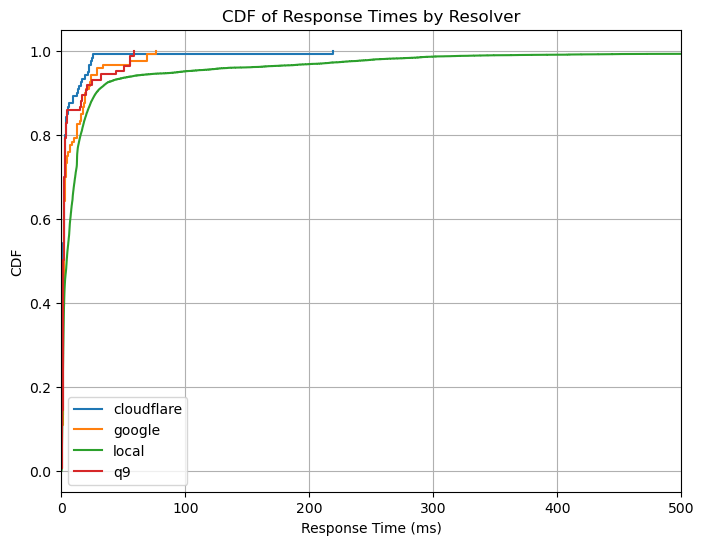

In [ ]:
plt.figure(figsize=(8, 6))
for resolver, group in df[(df['err'] == 0) & (df['rt'].notnull())].groupby('resolver'):
    sorted_rt = group['rt'].sort_values()
    y = sorted_rt.rank(method='max', pct=True)
    plt.step(sorted_rt, y, where='post', label=resolver)
plt.xlabel('Response Time (ms)')
plt.ylabel('CDF')
plt.title('CDF of Response Times by Resolver')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
plt.show()

## 4. CDF of Response Times by ASN (Only Successful Measurements)

**Note:** To plot by ASN, we need to merge probe ASN information. Please ensure you have a CSV mapping of probe IDs to ASNs (e.g., `probe_asn_mapping.csv`).

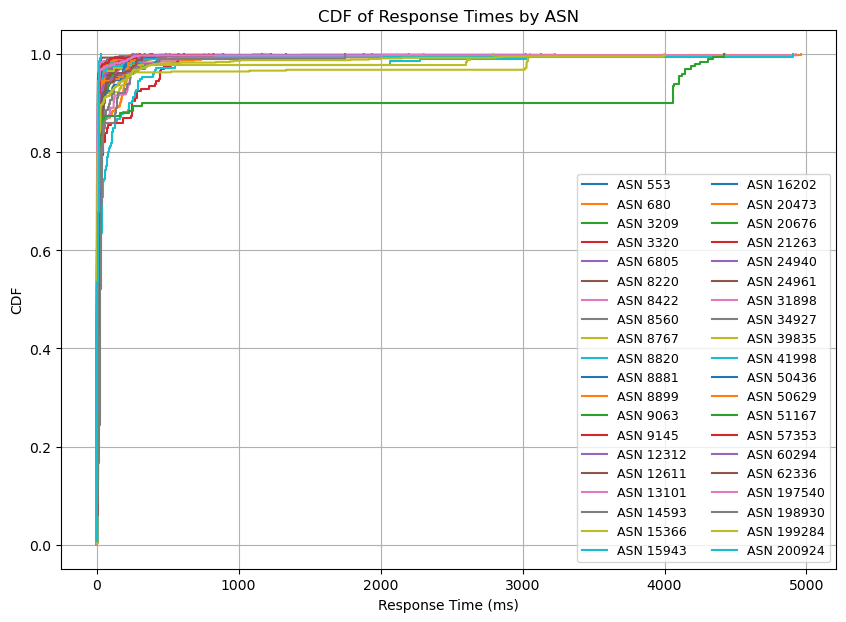

In [ ]:
asn_map = pd.read_csv('probe_asn_mapping.csv')
asn_map = asn_map.rename(columns={'probe_id': 'prb_id', 'asn_v4': 'asn'})
df_asn = df.merge(asn_map, on='prb_id', how='left')
plt.figure(figsize=(10, 7))
for asn, group in df_asn[(df_asn['err'] == 0) & (df_asn['rt'].notnull())].groupby('asn'):
    sorted_rt = group['rt'].sort_values()
    y = sorted_rt.rank(method='max', pct=True)
    plt.step(sorted_rt, y, where='post', label=f'ASN {asn}')
plt.xlabel('Response Time (ms)')
plt.ylabel('CDF')
plt.title('CDF of Response Times by ASN')
plt.legend(ncol=2, fontsize=9)
plt.grid(True)
plt.show()

## 5. CDF of Response Times by Continent (Only Successful Measurements)

**Note:** All probes are from Germany, so only Europe will be present.

For demonstration, we plot the CDF for Germany as a single group.

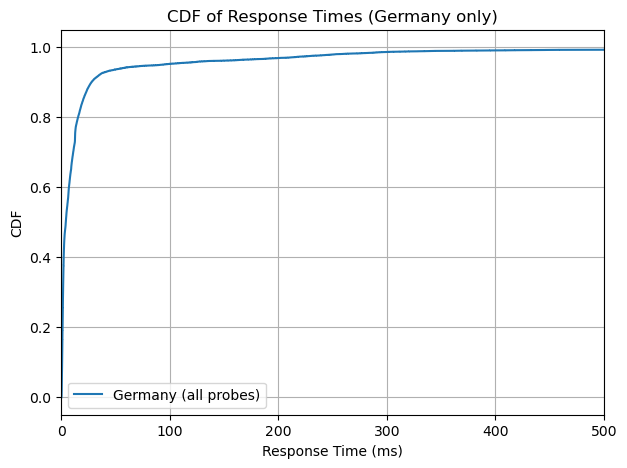

In [ ]:
plt.figure(figsize=(7, 5))
df_success = df[(df['err'] == 0) & (df['rt'].notnull())]
sorted_rt = df_success['rt'].sort_values()
y = sorted_rt.rank(method='max', pct=True)
plt.step(sorted_rt, y, where='post', label='Germany (all probes)')
plt.xlabel('Response Time (ms)')
plt.ylabel('CDF')
plt.title('CDF of Response Times (Germany only)')
plt.legend()
plt.grid(True)
plt.xlim(0, 500)
plt.show()